## Data Leakage
In questa esercitazione imparerete che cos'è la perdita di dati e come prevenirla. Se non si sa come prevenirla, la perdita di dati si presenterà spesso e rovinerà i modelli in modi sottili e pericolosi. Si tratta quindi di uno dei concetti più importanti per gli scienziati dei dati.


La perdita di dati (o **leakage**) si verifica quando i dati di addestramento contengono informazioni sull'obiettivo, ma dati simili non saranno disponibili quando il modello verrà utilizzato per la predizione. Questo porta a prestazioni elevate sul set di addestramento (e forse anche sui dati di validazione), ma il modello avrà prestazioni scarse in produzione.

In altre parole, le perdite fanno sì che un modello sembri accurato fino a quando non si iniziano a prendere decisioni con il modello, e poi il modello diventa molto impreciso.

Esistono due tipi principali di leakage: il **leakage del target** e la **contaminazione train-test**.

### Perdita di target
La perdita di target si verifica quando i predittori includono dati che non saranno disponibili nel momento in cui si effettuano le previsioni. È importante pensare al target leakage in termini di tempistica o di ordine cronologico in cui i dati diventano disponibili, non solo se una caratteristica aiuta a fare buone previsioni.

Un esempio può essere utile. Immaginate di voler prevedere chi si ammalerà di polmonite. Le prime righe dei dati grezzi hanno questo aspetto:

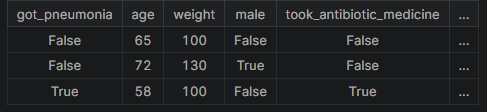

Le persone assumono farmaci antibiotici dopo aver contratto la polmonite per guarire. I dati grezzi mostrano una forte relazione tra queste colonne, ma la voce ha `took_antibiotic_medicine` viene spesso modificata dopo che è stato determinato il valore di ha `got_pneumonia`. Si tratta di una perdita di target.

Il modello vedrebbe che chiunque abbia un valore False per `took_antibiotic_medicine` non ha avuto la polmonite. Poiché i dati di convalida provengono dalla stessa fonte dei dati di addestramento, lo schema si ripeterà nella convalida e il modello avrà ottimi punteggi di convalida (o convalida incrociata).

Ma il modello sarà molto impreciso quando verrà utilizzato nel mondo reale, perché anche i pazienti che si ammaleranno di polmonite non avranno ancora ricevuto gli antibiotici quando dovremo fare previsioni sulla loro salute futura.

Per evitare questo tipo di perdita di dati, è necessario escludere qualsiasi variabile aggiornata (o creata) dopo la realizzazione del valore target.

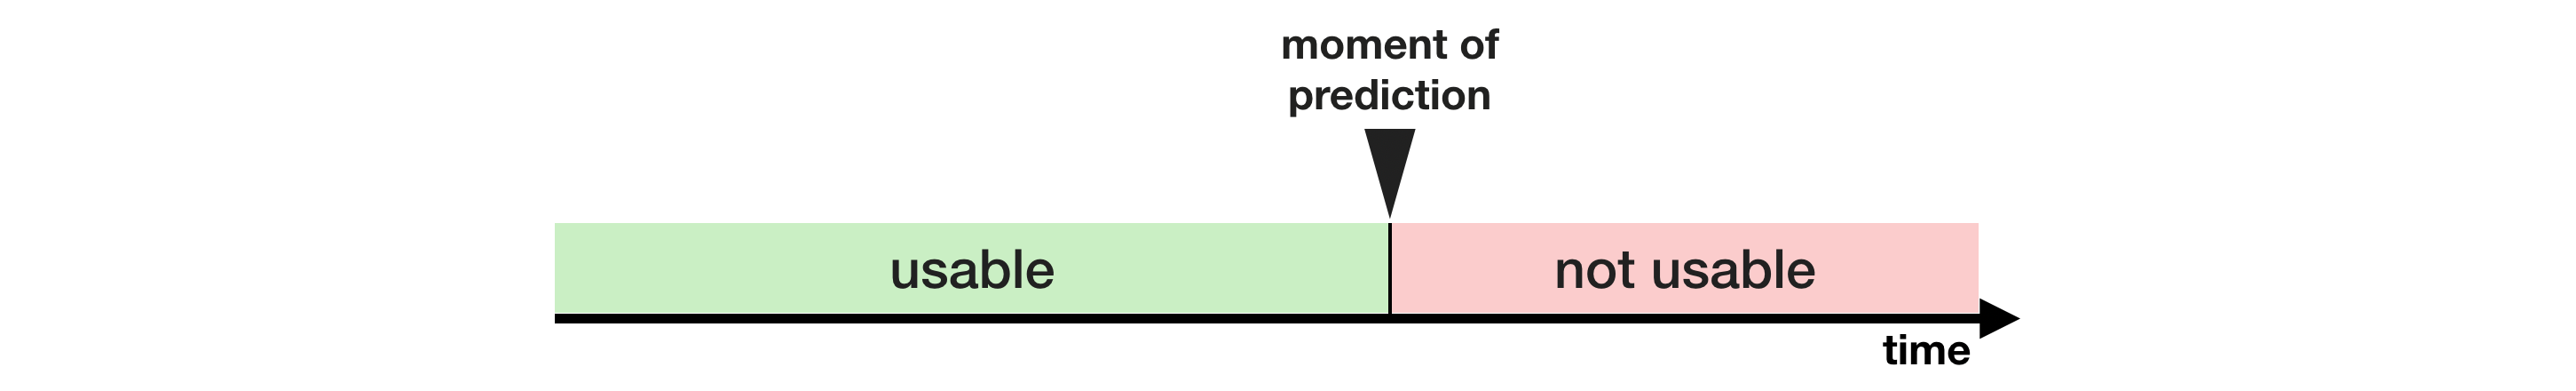

### Contaminazione treno-prova
Un altro tipo di **perdita** si verifica quando non si fa attenzione a distinguere i dati di addestramento da quelli di validazione.

Ricordiamo che la convalida è intesa come una misura di come il modello si comporta su dati che non ha mai considerato prima. È possibile corrompere questo processo in modo sottile se i dati di convalida influenzano il comportamento di preelaborazione. Questo fenomeno è talvolta chiamato contaminazione treno-test.

Per esempio, immaginiamo di eseguire una pre-elaborazione (come l'adattamento di un imput per i valori mancanti) prima di chiamare `train_test_split()`. Il risultato finale? Il vostro modello potrebbe ottenere buoni punteggi di validazione, dandovi una grande fiducia, ma ottenere scarsi risultati quando lo utilizzate per prendere decisioni.

Dopo tutto, i dati di convalida o di test sono stati incorporati nel modo in cui si fanno le previsioni, quindi il modello può andare bene su quei dati particolari, anche se non è in grado di generalizzarsi a nuovi dati. Questo problema diventa ancora più sottile (e più pericoloso) quando si fa un'ingegneria delle caratteristiche più complessa.

Se la convalida si basa su una semplice suddivisione treno-test, escludere i dati di convalida da qualsiasi tipo di adattamento, compreso l'adattamento delle fasi di preelaborazione. Questo è più facile se si utilizzano le `pipeline di scikit-learn`. Quando si utilizza la convalida incrociata, è ancora più importante eseguire la preelaborazione all'interno della pipeline!

### Esempio
In questo esempio, imparerete un modo per rilevare e rimuovere le perdite di target.

Utilizzeremo un set di dati sulle richieste di carte di credito e salteremo il codice di impostazione dei dati di base. Il risultato finale è che le informazioni su ogni richiesta di carta di credito sono memorizzate in un **DataFrame X**. Le utilizzeremo per prevedere quali richieste sono state accettate in una `Serie y`.

In [1]:
import pandas as pd

# Read the data
data = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/AER_credit_card_data.csv', 
                   true_values = ['yes'], false_values = ['no'])

# Select target
y = data.card

# Select predictors
X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


Poiché si tratta di un piccolo set di dati, utilizzeremo la convalida incrociata per garantire misure accurate della qualità del modello.

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Since there is no preprocessing, we don't need a pipeline (used anyway as best practice!)
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.978773


Con l'esperienza, si scoprirà che è molto raro trovare modelli che siano precisi il 98% delle volte. Succede, ma è abbastanza raro da indurci a ispezionare più da vicino i dati per individuare eventuali perdite di target.

Ecco un riepilogo dei dati, che potete trovare anche nella scheda dati:

- `card`: 1 se la richiesta di carta di credito è stata accettata, 0 in caso contrario
- `reports`: Numero di segnalazioni gravi e negative
- `age`: Età n anni più dodicesimi di anno
- `income`: Reddito annuale (diviso per 10.000)
- `share`: Rapporto tra la spesa mensile con carta di credito e il reddito annuale
- `expenditure`: Spesa media mensile con carta di credito
- `owner`: 1 se la casa è di proprietà, 0 se è in affitto
- `selfempl`: 1 se è autonomo, 0 se non lo è
- `dependents`: 1 + numero di persone a carico
- `months`: Mesi di vita all'indirizzo attuale
- `majorcards`: Numero di carte di credito principali possedute
- `active`: Numero di conti di credito attivi

Alcune variabili sembrano sospette. Ad esempio, per spese si intendono le spese effettuate con questa carta o con le carte utilizzate prima della richiesta?

A questo punto, il confronto dei dati di base può essere molto utile:

In [3]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


Come mostrato sopra, tutti coloro che non hanno ricevuto una carta non hanno avuto spese, mentre solo il 2% di coloro che hanno ricevuto una carta non ha avuto spese. Non sorprende che il nostro modello sembri avere un'elevata accuratezza. Ma questo sembra essere anche un caso di perdita di target, dove per spese si intendono probabilmente le spese per la carta richiesta.

Poiché la `share` è parzialmente determinata dalla `expenditure`, anche questa dovrebbe essere esclusa. Le variabili `active` e `majorcard` sono un po' meno chiare, ma dalla descrizione sembrano riguardare. Nella maggior parte delle situazioni, è meglio essere sicuri che dispiaciuti, se non è possibile rintracciare le persone che hanno creato i dati per saperne di più.

Eseguiremmo un modello senza perdita di target come segue:

In [4]:
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipeline, X2, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.833198


L'accuratezza è leggermente inferiore, il che potrebbe essere deludente. Tuttavia, possiamo aspettarci che abbia ragione circa l'80% delle volte quando viene utilizzato su nuove applicazioni, mentre il **modello leaky** probabilmente farebbe molto peggio (nonostante il suo punteggio apparente più alto nella **convalida incrociata**).

La perdita di dati può essere un errore multimilionario in molte applicazioni di scienza dei dati. Un'attenta separazione dei dati di addestramento e di convalida può prevenire la contaminazione tra addestramento e test, e le pipeline possono aiutare a implementare questa separazione. Allo stesso modo, una combinazione di cautela, buon senso ed esplorazione dei dati può aiutare a identificare le perdite di dati.

## Esercizi
La maggior parte delle persone trova la perdita di target molto complicata finché non ci pensa a lungo.

Quindi, prima di provare a pensare alla perdita di valore nell'esempio del prezzo delle case, esamineremo alcuni esempi in altre applicazioni. Le cose sembreranno più familiari quando si tornerà a una domanda sui prezzi delle case.

Le domande che seguono vi daranno un feedback sulle vostre risposte. Eseguite la seguente cella per impostare il sistema di feedback.

In [7]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex7 import *
print("Setup Complete")

Setup Complete


### Domanda 1
**La scienza dei dati sui lacci delle scarpe**

Nike vi ha assunto come consulente di data science per aiutarli a risparmiare sui materiali delle scarpe. Il vostro primo compito è quello di esaminare un modello costruito da uno dei loro dipendenti per prevedere quanti lacci avranno bisogno ogni mese. Le caratteristiche del modello di apprendimento automatico includono:
- Il mese corrente (gennaio, febbraio, ecc.)
- Le spese pubblicitarie del mese precedente
- varie caratteristiche macroeconomiche (come il tasso di disoccupazione) all'inizio del mese corrente
- La quantità di pelle che hanno finito per utilizzare nel mese corrente.

I risultati mostrano che il modello è quasi perfettamente accurato se si include la caratteristica della quantità di pelle utilizzata. Ma è solo moderatamente accurato se si esclude questa caratteristica. Questo perché la quantità di pelle utilizzata è un indicatore perfetto del numero di scarpe prodotte, che a sua volta indica il numero di lacci necessari.

Ritenete che la funzione `leather used` costituisca una fonte di perdita di dati? Se la vostra risposta è "dipende", da cosa dipende?

Dopo aver riflettuto sulla vostra risposta, verificatela con la soluzione qui sotto.

In [8]:
# Check your answer (Run this code cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

This is tricky, and it depends on details of how data is collected (which is common when thinking about leakage). Would you at the beginning of the month decide how much leather will be used that month? If so, this is ok. But if that is determined during the month, you would not have access to it when you make the prediction. If you have a guess at the beginning of the month, and it is subsequently changed during the month, the actual amount used during the month cannot be used as a feature (because it causes leakage).

### Domanda 2
**Il ritorno dei lacci delle scarpe**

Avete una nuova idea. Potreste utilizzare la quantità di pelle ordinata da Nike (piuttosto che quella effettivamente utilizzata) prima di un determinato mese come fattore predittivo nel vostro modello di lacci.

Questo cambia la vostra risposta sull'esistenza di un problema di perdite? Se risponde "dipende", da cosa dipende?

In [9]:
# Check your answer (Run this code cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

This could be fine, but it depends on whether they order shoelaces first or leather first. If they order shoelaces first, you won't know how much leather they've ordered when you predict their shoelace needs. If they order leather first, then you'll have that number available when you place your shoelace order, and you should be ok.

# Domanda 3
**Diventare ricchi con le criptovalute?**

Hai fatto risparmiare a Nike così tanto denaro che ti hanno dato un bonus. Congratulazioni.

Il vostro amico, che è anche uno scienziato dei dati, dice di aver costruito un modello che vi permetterà di trasformare il vostro bonus in milioni di dollari. In particolare, il suo modello prevede il prezzo di una nuova criptovaluta (come il **bitcoin**, ma più recente) un giorno prima del momento della previsione. Il suo piano consiste nell'acquistare la criptovaluta ogni volta che il modello dice che il prezzo della valuta (in dollari) sta per salire.

Le caratteristiche più importanti del suo modello sono:
- Prezzo attuale della valuta
- Quantità di valuta venduta nelle ultime 24 ore
- Variazione del prezzo della valuta nelle ultime 24 ore
- Variazione del prezzo della valuta nell'ultima ora
- Numero di nuovi tweet nelle ultime 24 ore che menzionano la valuta

Il valore della criptovaluta in dollari ha oscillato su e giù di oltre 100 dollari nell'ultimo anno, eppure l'errore medio del suo modello è inferiore a 1 dollaro. Egli sostiene che questa è la prova che il suo modello è accurato e che dovreste investire con lui, acquistando la valuta ogni volta che il modello dice che sta per salire.

Ha ragione? Se c'è un problema con il suo modello, qual è?

In [10]:
# Check your answer (Run this code cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

There is no source of leakage here. These features should be available at the moment you want to make a predition, and they're unlikely to be changed in the training data after the prediction target is determined. But, the way he describes accuracy could be misleading if you aren't careful. If the price moves gradually, today's price will be an accurate predictor of tomorrow's price, but it may not tell you whether it's a good time to invest. For instance, if it is $100 today, a model predicting a price of $100 tomorrow may seem accurate, even if it can't tell you whether the price is going up or down from the current price. A better prediction target would be the change in price over the next day. If you can consistently predict whether the price is about to go up or down (and by how much), you may have a winning investment opportunity.

### Domanda 4
**Prevenire le infezioni**

Un'agenzia che fornisce assistenza sanitaria vuole prevedere quali pazienti di un intervento chirurgico raro sono a rischio di infezione, in modo da avvisare il personale infermieristico di prestare particolare attenzione nel seguire quei pazienti.

Si vuole costruire un modello. Ogni riga del set di dati del modello sarà un singolo paziente che ha subito l'intervento chirurgico e l'obiettivo della previsione sarà se ha contratto un'infezione.

Alcuni chirurghi possono eseguire l'intervento in modo da aumentare o diminuire il rischio di infezione. Ma come si possono incorporare al meglio le informazioni sul chirurgo nel modello?

Avete un'idea intelligente. 
1. Prendete tutti gli interventi di ciascun chirurgo e calcolate il tasso di infezione tra questi chirurghi.
2. Per ogni paziente nei dati, scoprite chi era il chirurgo e inserite il tasso medio di infezione di quel chirurgo come caratteristica.

Questo comporta problemi di perdita di target?
Si pone qualche problema di contaminazione treno-test?

In [11]:
# Check your answer (Run this code cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

This poses a risk of both target leakage and train-test contamination (though you may be able to avoid both if you are careful).

You have target leakage if a given patient's outcome contributes to the infection rate for his surgeon, which is then plugged back into the prediction model for whether that patient becomes infected. You can avoid target leakage if you calculate the surgeon's infection rate by using only the surgeries before the patient we are predicting for. Calculating this for each surgery in your training data may be a little tricky.

You also have a train-test contamination problem if you calculate this using all surgeries a surgeon performed, including those from the test-set. The result would be that your model could look very accurate on the test set, even if it wouldn't generalize well to new patients after the model is deployed. This would happen because the surgeon-risk feature accounts for data in the test set. Test sets exist to estimate how the model will do when seeing new data. So this contamination defeats the purpose of the test set.

### Domanda 5 
**Prezzi delle abitazioni**

Costruirete un modello per prevedere i prezzi delle case.  Il modello verrà utilizzato su base continuativa, per prevedere il prezzo di una nuova casa quando viene aggiunta una descrizione a un sito web.  Ecco quattro caratteristiche che potrebbero essere utilizzate come predittori.
1. Dimensione della casa (in metri quadrati)
2. Prezzo medio di vendita delle case nello stesso quartiere
3. Latitudine e longitudine della casa
4. Se la casa ha un seminterrato

Si dispone di dati storici per addestrare e convalidare il modello.

Quale delle caratteristiche è più probabile che sia una fonte di perdita?

In [12]:
# Fill in the line below with one of 1, 2, 3 or 4.
potential_leakage_feature = 2 

# Check your answer
q_5.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

2 is the source of target leakage. Here is an analysis for each feature: 

1. The size of a house is unlikely to be changed after it is sold (though technically it's possible). But typically this will be available when we need to make a prediction, and the data won't be modified after the home is sold. So it is pretty safe. 

2. We don't know the rules for when this is updated. If the field is updated in the raw data after a home was sold, and the home's sale is used to calculate the average, this constitutes a case of target leakage. At an extreme, if only one home is sold in the neighborhood, and it is the home we are trying to predict, then the average will be exactly equal to the value we are trying to predict.  In general, for neighborhoods with few sales, the model will perform very well on the training data.  But when you apply the model, the home you are predicting won't have been sold yet, so this feature won't work the same as it did in the training data. 

3. These don't change, and will be available at the time we want to make a prediction. So there's no risk of target leakage here. 

4. This also doesn't change, and it is available at the time we want to make a prediction. So there's no risk of target leakage here.